In [1]:
import os
ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
print(ROOT)

/home/saisampathkedari/MonteCarlo-Statistical-Methods


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy

In [3]:
from utils.montecarlo import *
from variance_reduction.control_variate import *

## Example 1: Estimating an Integral Using Control Variates

Consider estimating the integral  
$$
I_g = \int_0^1 g(x)\,dx,
\qquad
g(x) = e^{-x^2}.
$$

There is no closed-form expression for this integral using elementary functions.  
However, we can reinterpret it as an expectation with respect to a uniform random variable.

Let  
$$
X \sim \mathcal{U}[0,1],
$$
then  
$$
I_g 
= \mathbb{E}[g(X)]
= \mathbb{E}[e^{-X^2}].
$$

Under this formulation, a natural Monte Carlo estimator for $I_g$ is  
$$
\hat{I}_g 
= \frac{1}{n}\sum_{i=1}^n g(X_i),
\qquad
X_i \stackrel{iid}{\sim} \mathcal{U}[0,1].
$$

The function $g(x)$ is smooth and decreasing on $[0,1]$, and its numerical plot is shown below. For reference, the exact value is computed below function definition of g is shown below


In [4]:
x = sympy.Symbol('x')
exact = sympy.integrate( sympy.exp(-x**2), (x, 0, 1))
print("Exact Integral = ", exact)
print("Approximate Value = ", float(exact))

Exact Integral =  sqrt(pi)*erf(1)/2
Approximate Value =  0.746824132812427


### Control Variate Choice and Its Exact Expectation

To improve the Monte Carlo estimate of $I_g$, we introduce a control variate
that is easy to integrate analytically.  
A natural choice, motivated by the first–order Taylor expansion of $e^{-x^2}$, is
$$
h(x) = 1 - x^2.
$$

Since $X \sim \mathcal{U}[0,1]$, the expectation of $h(X)$ is
$$
\mathbb{E}[h(X)]
= \int_0^1 (1 - x^2)\,dx.
$$

Evaluating this integral,
$$
\mathbb{E}[h(X)]
= \left[x - \frac{x^3}{3}\right]_{0}^{1}
= 1 - \frac{1}{3}
= \frac{2}{3}.
$$

Thus the control variate $h(x)$ has a known closed-form expectation,
$$
I_h = \mathbb{E}[h(X)] = \frac{2}{3}.
$$


### Comparison of the Target Function and Control Variate

Let us compare the behavior of the target function $g(x) = e^{-x^2}$ and the control variate 
$h(x) = 1 - x^2$ on the interval $[0,1]$.  
Both functions are smooth, decreasing, and concave on this domain, which visually explains why
they tend to be strongly correlated.  
This similarity is the key reason why $h(x)$ is an effective control variate for estimating $I_g$.


In [5]:
def g(x : np.ndarray) -> np.ndarray:
    """Test function: "High-fidelity" (Expensive) model """
    return np.exp(-x**2)

def h(x : np.ndarray) -> np.ndarray:
    """Additional information source: "low-fidelity" (inexpensive) model """
    return 1 - x**2

h_expected_val = 2/3

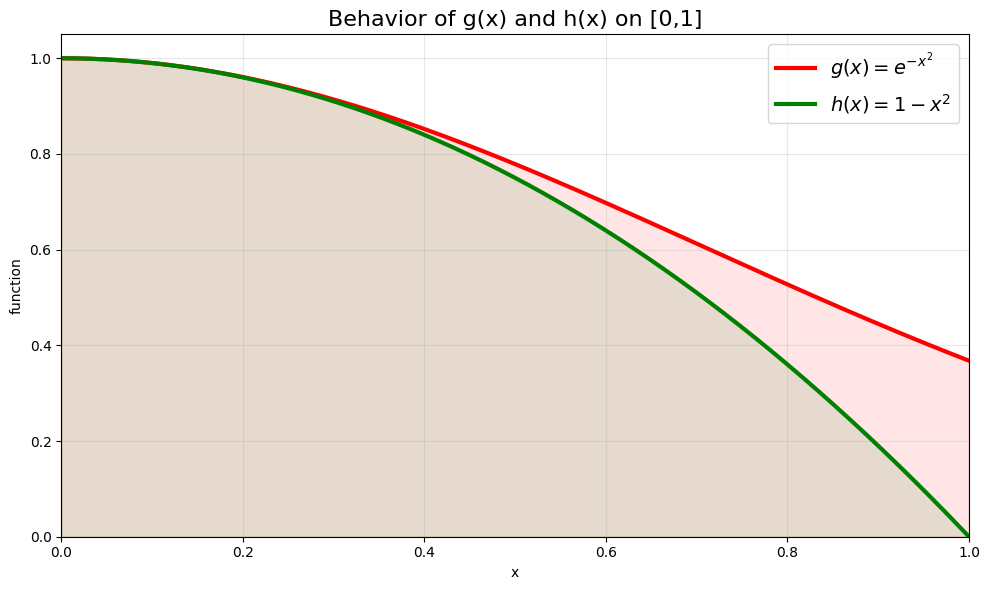

In [7]:
x = np.linspace(0, 1, 2000)
g_vals = g(x)
h_vals = h(x)

plt.figure(figsize=(10,6))
plt.plot(x, g_vals, color='red', linewidth=3, label=r"$g(x) = e^{-x^2}$")
plt.plot(x, h_vals, color='green', linewidth=3, label=r"$h(x) = 1 - x^2$")

# Highlight region of interest
plt.fill_between(x, g_vals, 0, color='red', alpha=0.1)
plt.fill_between(x, h_vals, 0, color='green', alpha=0.1)


plt.xlabel("x")
plt.ylabel("function")
plt.title("Behavior of g(x) and h(x) on [0,1]", fontsize=16)

plt.xlim(0,1)
plt.ylim(0,)
plt.legend(fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
save_path_1 = os.path.join(ROOT, "images/variance_reduction/g_vs_h_plot.png")
plt.savefig(
    save_path_1,
    dpi=300,
    bbox_inches='tight'
)
plt.show()

### Monte Carlo Baseline Estimate

Before applying control variates, we begin with a standard Monte Carlo estimate of  
$$
I_g = \mathbb{E}[g(X)], 
\qquad 
g(x) = e^{-x^2}, 
\qquad 
X \sim \mathcal{U}[0,1].
$$

Using $n = 100$ independent samples, the Monte Carlo estimator and its standard error are computed below:


In [8]:
num_samples = 100
mc_g = monte_carlo(num_samples, np.random.rand, g_evaluator=g)
MC_stderr = np.std(mc_g.evaluations) / np.sqrt(num_samples)  # estimated standard error from the same samples
MC_Estimate_err = np.abs(float(exact) - mc_g.estimate)
print(f"MC Estimate = {mc_g.estimate:6f}")
print(f"Exact Error = {MC_Estimate_err:6f}")
print(f"MC Estimated Error = {MC_stderr:6f}")

MC Estimate = 0.751575
Exact Error = 0.004751
MC Estimated Error = 0.020179


## Control Variate Estimate

We now apply the control variate method using  
$$
h(x) = 1 - x^2,
$$
whose expectation $\mathbb{E}[h(X)] = 2/3$ is known exactly.  
The optimal control variate weight $\alpha^{*}$ is estimated from the sample covariance
between $g(X)$ and $h(X)$, using the same Monte Carlo samples.

The control variate estimator is  
$$
\hat{I}_{CV} 
= \hat{I}_{g} + \alpha^{*} \left( \hat{I}_{h} - \mathbb{E}[h(X)] \right),
$$

which has variance  
$$
\mathrm{Var}(\hat{I}_{CV}) 
= \frac{1}{n}\mathrm{Var}(g)\,(1 - \rho^{2}),
$$

where $\rho$ is the sample correlation between $g(X)$ and $h(X)$.


In [9]:
num_samples = 100
cv_g = control_variate(num_samples,np.random.rand,g,h,h_expected=h_expected_val)
cv_stderr = np.sqrt(cv_g.cov[0, 0] / num_samples * (1 - cv_g.correlation**2))  # standard error
cv_Estimate_err = np.abs(float(exact) - cv_g.mc_g.estimate)
print(f"CV Estimate = {cv_g.mc_g.estimate:6f}")
print(f"Exact Error = {cv_Estimate_err:6f}")
print(f"CV Estimated Error = {cv_stderr:6f}")

CV Estimate = 0.734962
Exact Error = 0.011862
CV Estimated Error = 0.002456


### Variance Comparison of Monte Carlo and Control Variates

To visualize the effect of variance reduction, we generate $500$ independent 
Monte Carlo and Control Variate estimates using $n = 100$ samples each. 
The resulting histograms are shown in below plot

The reduction in variability is dramatic. Quantitatively, we observe
$$
\sigma_{\text{MC}} \approx 2.01 \times 10^{-2},
\qquad
\sigma_{\text{CV}} \approx 2.39 \times 10^{-3}.
$$

This corresponds to roughly an **eight- to ten-fold reduction** in the 
standard deviation of the estimator.  
The CV estimates form a narrow, concentrated cluster around the exact value,
while the MC estimates remain widely spread.


Std of Error with MC= 1.952849E-02
Std of Error with CV= 2.576874E-03


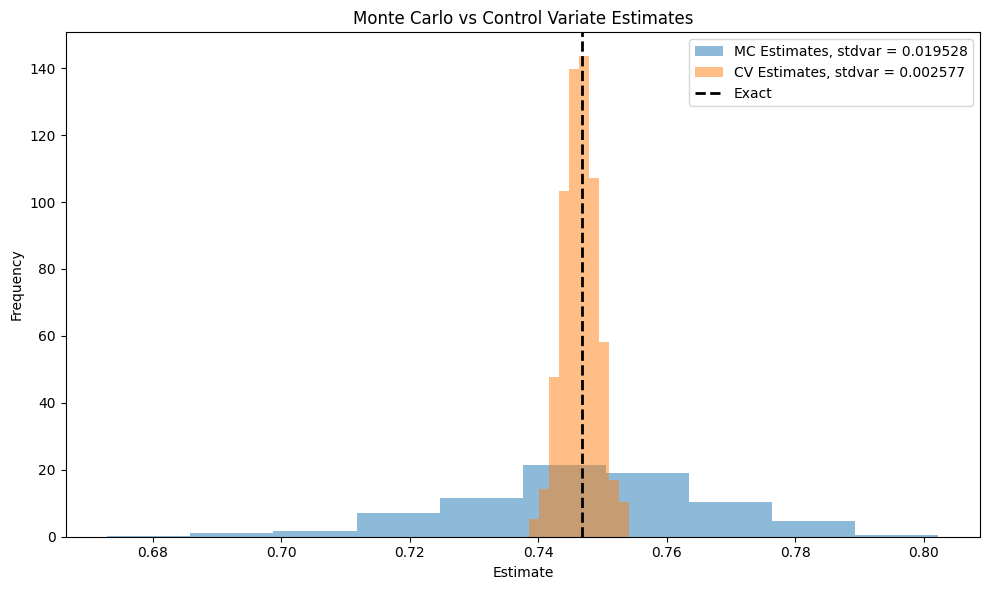

In [10]:
ntrails = 500
num_samples = 100

Estimates_MC = np.zeros(ntrails)
Estimates_CV = np.zeros(ntrails)

for i in range(ntrails):
    Estimates_MC[i] =  monte_carlo(num_samples, np.random.rand, g_evaluator=g).estimate
    Estimates_CV[i] = control_variate(num_samples,np.random.rand,g,h,h_expected=h_expected_val).estimate_cv

stdvar_mc = np.std(Estimates_MC)
stdvar_cv = np.std(Estimates_CV)

plt.figure(figsize=(10,6))
plt.hist(Estimates_MC, bins=10, density=True, alpha=0.5, label=f'MC Estimates, stdvar = {stdvar_mc:5f}', color='C0')
plt.hist(Estimates_CV, bins=10, density=True, alpha=0.5, label=f'CV Estimates, stdvar = {stdvar_cv:5f}', color='C1')
plt.axvline(float(exact), color='black', linestyle='--', linewidth=2, label='Exact')

plt.title("Monte Carlo vs Control Variate Estimates")
plt.xlabel("Estimate")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
save_path_2 = os.path.join(ROOT, "images/variance_reduction/mc_vs_cv_var.png")
plt.savefig(
    save_path_2,
    dpi=300,
    bbox_inches='tight'
)

print("Std of Error with MC= {:5E}".format(np.std(Estimates_MC)))
print("Std of Error with CV= {:5E}".format(np.std(Estimates_CV)))

plt.show()